In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [21]:
"""Program to simulate the X-ray spectra and color of NS and CV spectra.

Functions needed:
1. Choose a random source and collect the corresponding response and background
2. A random distribution of NH and power-law for the NS spectra.
3. Random distribution of NH, power-law and Fe-line eq width for CV
4. Fake-it simulations.
Analysis should be done both for PN and MOS
"""


import copy
import glob2
import os
import xspec
import numpy as np
from astropy.io import fits


def get_resp(src_file, obs_folder='./', rmf_folder='./'):
    """Get background and responses for the given source file.

    Inputs:
    src_file = Combined source file
    obs_folder - Folder containing individual observations of the source
    """
    spectra_header = fits.open(src_file)[1].header
    bg_file = obs_folder + spectra_header['BACKFILE']
    arf_file = obs_folder + spectra_header['ANCRFILE']
    resp_file = rmf_folder + spectra_header['RESPFILE']
    exptime = spectra_header['EXPOSURE']
    file_list = [bg_file, arf_file, resp_file]
    for i, file in enumerate(file_list):
        if file.split('/')[-1] == 'None':
            file_list[i] = ''
    return file_list[0], file_list[1], file_list[2], exptime


def sim_msp(resp_file, arf_file, bg_file, exp_s, sim_msp_name, nh_val,
            gamma_val, unabs_lx_val):
    """Simulate the MSP spectra with the given values."""
    msp_settings = xspec.FakeitSettings(
        response=resp_file, arf=arf_file, background=bg_file, exposure=exp_s,
        fileName=sim_msp_name)
    msp_model = xspec.Model('tbabs*pegpwrlw')
    unabs_flux = unabs_lx_val/(7.65757E+45)
    msp_model.setPars({1: nh_val/1.0E+22, 2: gamma_val, 3: 2, 4: 10,
                       5: unabs_flux/1.0E-12})
    xspec.AllData.fakeit(1, msp_settings)
    xspec.AllData.clear()
    xspec.AllModels.clear()


def sim_msp_from_src(src_file, sim_msp_name, nh_val, gamma_val,
                     unabs_lx_val):
    """Simulate MSP spectra from a source spectra."""
    msp_settings = xspec.FakeitSettings(fileName=sim_msp_name)
    spectrum = xspec.Spectrum(src_file)
    msp_model = xspec.Model('tbabs*pegpwrlw')
    unabs_flux = unabs_lx_val/(7.65757E+45)
    msp_model.setPars({1: nh_val/1.0E+22, 2: gamma_val, 3: 2, 4: 10,
                       5: unabs_flux/1.0E-12})
    xspec.AllData.fakeit(1, msp_settings)
    xspec.AllData.clear()
    xspec.AllModels.clear()


def sim_cv_from_src(src_file, sim_msp_name, nh_val, temp_val, unabs_lx_val,
                    ew_64, ew_67, ew_70):
    """Simulate apec spectra"""
    ip_settings = xspec.FakeitSettings(fileName=sim_msp_name)
    spectrum = xspec.Spectrum(src_file)
    xspec.Xset.addModelString("APECNOLINES", "no")
    xspec.Xset.abund = 'wilm'
    ip_model = xspec.Model("tbabs*cflux*apec")
    unabs_flux = unabs_lx_val/(7.65757E+45)
    ip_model.setPars({1: nh_val/1.0E+22, 2: 2.0, 3: 10.0,
                      4: np.log10(unabs_flux), 5: temp_val, 6: 3.0})
    #xspec.Plot.device = "/xw"
    #xspec.Plot("model")
    #xspec.AllModels.show()
    xspec.AllData.fakeit(1, ip_settings)
    xspec.AllData.clear()
    xspec.AllModels.clear()
    

'''
def sim_cv_from_src(src_file, sim_msp_name, nh_val, temp_val, unabs_lx_val,
                    ew_64, ew_67, ew_70):
    """Simulate spectra of CVs."""
    ip_settings = xspec.FakeitSettings(fileName=sim_msp_name)
    spectrum = xspec.Spectrum(src_file)
    xspec.Xset.addModelString("APECNOLINES", "no")
    xspec.Xset.abund = 'wilm'
    ip_model = xspec.Model("tbabs*(apec+gaussian+gaussian+gaussian)")
    unabs_flux = unabs_lx_val/(7.65757E+45)
    ip_model.setPars({1: nh_val/1.0E+22, 2: temp_val, 6: 6.4, 8: 1.0E-4, 9: 6.7,
                      11: 1.0E-4, 12: 7.0, 14: 1.0E-4})
    xspec.AllModels.eqwidth(3, rangeFrac=0.0)
    test_ew_64 = spectrum.eqwidth[0]
    xspec.AllModels.eqwidth(4, rangeFrac=0.0)
    test_ew_67 = spectrum.eqwidth[0]
    xspec.AllModels.eqwidth(5, rangeFrac=0.0)
    test_ew_70 = spectrum.eqwidth[0]
    norm_64 = ew_64/test_ew_64*1.0E-4*2
    norm_67 = ew_67/test_ew_67*1.0E-4*2
    norm_70 = ew_70/test_ew_70*1.0E-4*2
    xspec.AllModels.clear()
    ip_model = xspec.Model("tbabs*cflux*(apec+gaussian+gaussian+gaussian)")
    xspec.Xset.addModelString("APECNOLINES", "yes")
    ip_model.setPars({1: nh_val/1.0E+22, 2: 2.0, 3: 10.0,
                      4: np.log10(unabs_flux), 5: temp_val, 9: 6.4,
                      11: norm_64, 12: 6.7, 14: norm_67, 15: 7.0, 17: norm_70})

    xspec.Plot.device = "/xw"
    xspec.Plot("model")
    xspec.AllModels.show()
    xspec.AllData.fakeit(1, ip_settings)
    xspec.AllData.clear()
    xspec.AllModels.clear()
'''

def msp_simulations(num_msps, nh_vals, gamma_vals, unabs_lx_vals,
                    resp_files=None, arf_files=None, bg_files=None,
                    obs_folder=None, rmf_folder=None, exp_times=None,
                    sim_msp_folder='./'):
    """Simulate MSPs."""
    if resp_files is None:
        if obs_folder is None or rmf_folder is None:
            raise ValueError('Either give the response files explicitly or' +
                             'give the observation and rmf folders from which'
                             + 'they should be sampled')
        src_files = glob2.glob(obs_folder + '*_src_grp.ds')
        src_files_forsim = np.random.choice(src_files, size=num_msps)

    for i, msp_num in enumerate(num_msps):
        if resp_files is None:
            bg_file, arf_file, resp_file, exptime = get_resp(
                src_files_forsim[i], obs_folder=obs_folder,
                rmf_folder=rmf_folder)
        else:
            bg_file = bg_files[i]
            arf_file = arf_files[i]
            resp_file = resp_files[i]
            exptime = exp_times[i]

        sim_msp(resp_file, arf_file, bg_file, exptime,
                sim_msp_folder+'msp_'+str(i)+'.fak', nh_vals[i], gamma_vals[i],
                unabs_lx_vals[i])
        if i % 1000 == 0:
            print('Finished ' + str(i) + 'simulations')


def get_xmm_src_files(src_folder):
    """Get PN and MOS src files."""
    pn_src_files = glob2.glob(src_folder + '*_PN_*src_grp1*cts.ds')
    mos_src_files = glob2.glob(src_folder + '*_MOS_*src_grp1*cts.ds')
    # pn_mos_png_files = glob2.glob(src_folder + '*_PN_MOS_combined_src.png')
    common_files_pn = []
    common_files_mos = []
    only_pn_files = copy.copy(pn_src_files)
    only_mos_files = copy.copy(mos_src_files)
    for pn_file in pn_src_files:
        pn_src_num = pn_file.split('/')[-1].split('_')[0]
        if os.path.isfile(src_folder + pn_src_num +
                          '_MOS_combined_src_grp.ds'):
            mos_file = glob2.glob(src_folder + pn_src_num +
                                  '_MOS_combined_src_grp1*cts.ds')[0]
            common_files_pn.append(pn_file)
            common_files_mos.append(mos_file)
            only_pn_files.remove(pn_file)
            only_mos_files.remove(mos_file)
    return common_files_pn, common_files_mos, only_pn_files, only_mos_files


def get_src_nums(src_file_list):
    src_nums = []
    for src_file in src_file_list:
        src_num = src_file.split('/')[-1].split('_')[0]
        src_nums.append(src_num)
    return src_nums


def msp_sims_from_src(num_msps, nh_vals, gamma_vals, unabs_lx_vals, src_folder,
                      sim_msp_folder='./', file_prefix='msp_'):
    """Simulate MSPs rom source files."""
    (common_files_pn, common_files_mos, only_pn_files,
     only_mos_files) = get_xmm_src_files(src_folder)
    src_files = common_files_pn + only_pn_files + only_mos_files
    src_args_forsim = np.random.choice(
        np.arange(len(src_files)), size=num_msps)
    for i in range(num_msps):
        if src_args_forsim[i] < len(common_files_pn) + len(only_pn_files):
            sim_msp_from_src(
                src_files[src_args_forsim[i]],
                sim_msp_folder + file_prefix + str(i) + '_PN.fak',
                nh_vals[i], gamma_vals[i], unabs_lx_vals[i])
            if src_args_forsim[i] < len(common_files_pn):
                sim_msp_from_src(
                    common_files_mos[src_args_forsim[i]],
                    sim_msp_folder + file_prefix + str(i) + '_MOS.fak',
                    nh_vals[i], gamma_vals[i], unabs_lx_vals[i])
        else:
            sim_msp_from_src(
                src_files[src_args_forsim[i]],
                sim_msp_folder + file_prefix + str(i) + '_MOS.fak',
                nh_vals[i], gamma_vals[i], unabs_lx_vals[i])

        if i % 1000 == 0:
            print('Finished ' + str(i) + ' simulations')


def cvs_sims_from_src(num_cvs, nh_vals, temp_vals, unabs_lx_vals, ew_64_vals,
                      ew_67_vals, ew_70_vals, src_folder, sim_cv_folder='./',
                      file_prefix='cv_'):
    """"Simulate MSPs from source files."""
    (common_files_pn, common_files_mos, only_pn_files,
     only_mos_files) = get_xmm_src_files(src_folder)
    src_files = common_files_pn + only_pn_files + only_mos_files
    src_args_forsim = np.random.choice(
        np.arange(len(src_files)), size=num_cvs)
    for i in range(num_cvs):
        if src_args_forsim[i] < len(common_files_pn) + len(only_pn_files):
            
            sim_cv_from_src(
                src_files[src_args_forsim[i]],
                sim_cv_folder + file_prefix + str(i) + '_PN.fak', nh_vals[i],
                temp_vals[i], unabs_lx_vals[i], ew_64_vals[i], ew_67_vals[i],
                ew_70_vals[i])
            if src_args_forsim[i] < len(common_files_pn):
                sim_cv_from_src(
                    common_files_mos[src_args_forsim[i]],
                    sim_cv_folder + file_prefix + str(i) + '_MOS.fak',
                    nh_vals[i], temp_vals[i], unabs_lx_vals[i], ew_64_vals[i],
                    ew_67_vals[i], ew_70_vals[i])
        else:
            sim_cv_from_src(
                src_files[src_args_forsim[i]],
                sim_cv_folder + file_prefix + str(i) + '_MOS.fak', nh_vals[i],
                temp_vals[i], unabs_lx_vals[i], ew_64_vals[i], ew_67_vals[i],
                ew_70_vals[i])

        if i % 1000 == 0:
            print('Finished ' + str(i) + ' simulations')


def get_msp_param_vals(num_msps, nh_abs_type):
    """Get parameter values for the MSP simulations."""
    if nh_abs_type == 'high':
        nh_vals = np.random.uniform(22.7, 23.7, num_msps)
    elif nh_abs_type == 'mid':
        nh_vals = np.random.uniform(22.0, 22.7, num_msps)
    elif nh_abs_type == 'low':
        nh_vals = np.random.uniform(21.0, 22.0, num_msps)
    else:
        print("'nh_abs_type' should be 'high', 'mid', or 'low'.")
    nh_vals = 10**nh_vals
    gamma_vals = np.random.uniform(1.0, 2.0, num_msps)
    lx_vals = np.random.uniform(31.0, 34.0, num_msps)
    lx_vals = 10**lx_vals
    return nh_vals, gamma_vals, lx_vals


def get_cv_param_vals(num_cvs, nh_abs_type, cv_type='IP'):
    """"Get parameter values for IP simulations."""
    if nh_abs_type == 'high':
        nh_vals = np.random.uniform(22.7, 23.7, num_cvs)
    elif nh_abs_type == 'mid':
        nh_vals = np.random.uniform(22.0, 22.7, num_cvs)
    elif nh_abs_type == 'low':
        nh_vals = np.random.uniform(21.0, 22.0, num_cvs)
    else:
        print("'nh_abs_type' should be 'high', 'mid', or 'low'.")
    nh_vals = 10**nh_vals
    lx_vals = np.random.uniform(31.0, 34.0, num_cvs)
    lx_vals = 10**lx_vals
    if cv_type == 'IP':
        temp_vals = np.random.normal(34.0, 4.54, num_cvs)
        ew_64_vals = np.random.normal(0.115, 0.00912, num_cvs)
        ew_67_vals = np.random.normal(0.107, 0.016, num_cvs)
        ew_70_vals = np.random.normal(0.08, 0.00681, num_cvs)
    elif cv_type == 'SS':
        temp_vals = np.random.normal(27.2, 20.8, num_cvs)
        ew_64_vals = np.random.normal(0.280, 0.090, num_cvs)
        ew_67_vals = np.random.normal(0.241, 0.0783, num_cvs)
        ew_70_vals = np.random.normal(0.091, 0.0201, num_cvs)
    else:
        print('CV types can only be IP or SS')
    return nh_vals, temp_vals, lx_vals, ew_64_vals, ew_67_vals, ew_70_vals


58:5: F841 local variable 'spectrum' is assigned to but never used
72:5: F841 local variable 'spectrum' is assigned to but never used
79:5: E265 block comment should start with '# '
80:5: E265 block comment should start with '# '
81:5: E265 block comment should start with '# '
85:1: W293 blank line contains whitespace
97:80: E501 line too long (80 > 79 characters)
123:1: E302 expected 2 blank lines, found 1
224:1: W293 blank line contains whitespace


In [4]:
ss2_param_vals = get_cv_param_vals(num_cvs=10000, nh_abs_type='high',
                                   cv_type='SS')

In [14]:
nh_vals, temp_vals, lx_vals, ew_64_vals, ew_67_vals, ew_70_vals = ss2_param_vals

In [23]:
os.chdir('../data/')

In [24]:
os.getcwd()

'/Users/pavanrh/Documents/UofA_projects/GalacticBulge_Xrayclassify/data'

In [8]:
import matplotlib.pyplot as plt

In [16]:
temp_vals[temp_vals < 3] = 3

In [19]:
ew_70_vals[ew_70_vals < 0] = 0

(array([2.636e+03, 1.916e+03, 2.109e+03, 1.643e+03, 9.770e+02, 5.040e+02,
        1.650e+02, 3.900e+01, 1.000e+01, 1.000e+00]),
 array([  3.        ,  14.05771179,  25.11542359,  36.17313538,
         47.23084717,  58.28855897,  69.34627076,  80.40398255,
         91.46169435, 102.51940614, 113.57711793]),
 <BarContainer object of 10 artists>)

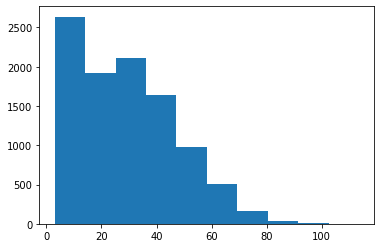

In [20]:
plt.hist(temp_vals)

In [25]:
cvs_sims_from_src(10000, nh_vals, temp_vals, lx_vals, ew_64_vals,
                  ew_67_vals, ew_70_vals, 'Galactic_highNH_combinedXMM/',
                  sim_cv_folder='./sim_apec_highnh_ss/', file_prefix='ss_')

Finished 0 simulations
Finished 1000 simulations
Finished 2000 simulations
Finished 3000 simulations
Finished 4000 simulations
Finished 5000 simulations
Finished 6000 simulations
Finished 7000 simulations
Finished 8000 simulations
Finished 9000 simulations


In [93]:
ew_70_vals[1]

0.07219417018249723

In [95]:
lx_vals[:20]

array([1.02534804e+31, 3.10186647e+32, 5.95394977e+32, 5.19084320e+31,
       1.81635802e+33, 9.45030018e+31, 1.13262838e+31, 2.21416128e+32,
       6.31557121e+31, 1.01550721e+32, 3.86252139e+31, 8.36949315e+32,
       1.93971147e+31, 6.84566740e+33, 1.52140126e+31, 1.02648963e+32,
       1.76533187e+32, 1.18106069e+32, 1.51154328e+33, 8.16333488e+31])

In [25]:
nh_vals[:10]

array([9.24266132e+22, 4.74292175e+23, 6.58610551e+22, 3.39991463e+23,
       7.23386416e+22, 1.58053288e+23, 2.65934056e+23, 3.51241101e+23,
       4.89569701e+23, 8.76156497e+22])

In [103]:
xspec.AllData.clear()

In [150]:
ss_param_vals_refined = np.column_stack(
    [nh_vals, temp_vals, lx_vals, ew_64_vals, ew_67_vals, ew_70_vals])

In [172]:
np.savetxt('sim_apec_highnh/IPs_param_values.txt', ips_param_vals)

In [106]:
nh_vals[:5]

array([5.70073510e+22, 6.85234244e+22, 3.69795545e+23, 1.60892986e+23,
       2.49112443e+23])

In [107]:
lx_vals[:5]

array([1.02534804e+31, 3.10186647e+32, 5.95394977e+32, 5.19084320e+31,
       1.81635802e+33])

In [108]:
temp_vals[:5]

array([27.74572699, 27.78401953, 29.14309398, 32.61770821, 36.09908935])

In [109]:
ew_64_vals[:5]

array([0.11512985, 0.12661786, 0.10871165, 0.11908214, 0.12300042])

In [110]:
ew_67_vals[:5]

array([0.07473885, 0.09738611, 0.09253189, 0.11387557, 0.11407345])

In [111]:
ew_70_vals[:5]

array([0.08251298, 0.07219417, 0.08580137, 0.08617561, 0.09438578])

In [128]:
ip_param_vals[0]

array([5.70073510e+22, 6.85234244e+22, 3.69795545e+23, ...,
       4.84049412e+23, 4.06220533e+23, 3.11004953e+23])